In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import collections
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from concepts import concept_instances
from utils import load_data, prepare_folders, load_q_network_device

In [3]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [4]:
# increase hyperparams for more accurate results, but longer computation time
max_data_size = 3000
k_fold = 10
max_training_iter = 50

In [5]:
models_path = "../runs/20230927-233906/models/"
models = os.listdir(models_path)
# get num steps from file name
models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
# sort on the number of steps
models.sort(key=lambda x: x[1])

In [6]:
data = load_data()
for concept in concept_instances.values():
    prepare_folders(concept.path)
    concept.prepare_data(data, max_size=max_data_size)

In [7]:
layers = [0,1,2,3,4,5,7,8]
train_steps = [m[1] for m in models]
scores = {}

# setup 3d data structures for plotting
for concept in concept_instances.values():
    scores[concept.name] = {}
    x, y = np.meshgrid(train_steps, layers)
    scores[concept.name]['x'] = x
    scores[concept.name]['y'] = y
    scores[concept.name]['z'] = np.zeros((len(layers), len(train_steps)))

In [8]:
best_Cs = []
# binary accuracy normalized with random guessing (balanced dataset!)
def calculate_accuracy(train_acts, train_values, test_acts, test_values):
    Cs = [0.001, 0.01, 1.0, 10]
    reg = linear_model.LogisticRegressionCV(max_iter=max_training_iter, cv=k_fold, Cs=Cs)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = 2*accuracy_score(test_values, pred)-1
    print((reg.C_[0], score), end=' ')
    best_Cs.append(reg.C_[0])
    return reg, 2*score - 1

In [9]:
best_alphas = []
def calculate_r2(train_acts, train_values, test_acts, test_values):
    alphas = [0.0001, 0.001, 0.01, 1, 10]
    reg = linear_model.LassoCV(max_iter=max_training_iter, cv=k_fold, alphas=alphas)
    reg.fit(train_acts, train_values)
    pred = reg.predict(test_acts)
    score = r2_score(test_values, pred)
    print((reg.alpha_, score), end=' ')
    best_alphas.append(reg.alpha_)
    return reg, score

In [10]:
# calculate test accuracy for each point: (concept, training_step, layer)
for model_name in models:
    model, steps = model_name
    steps_index = train_steps.index(steps)
    q_network, device = load_q_network_device(models_path + model)
    print("Loaded model: ", model)
    for concept in concept_instances.values():
        print()
        print(concept.name)
        _, train_acts_dict = q_network(torch.tensor(concept.obs_train).to(device), return_acts=True)
        _, test_acts_dict = q_network(torch.tensor(concept.obs_test).to(device), return_acts=True)
        train_values = concept.values_train
        test_values = concept.values_test

        for layer_index, layer in enumerate(layers):
            train_acts = train_acts_dict[str(layer)].cpu().detach().numpy()
            test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
            train_acts = train_acts.reshape(len(train_acts), -1)
            test_acts = test_acts.reshape(len(test_acts), -1)

            if concept.binary:
                reg, score = calculate_accuracy(train_acts, train_values, test_acts, test_values)
            else:
                reg, score = calculate_r2(train_acts, train_values, test_acts, test_values)
            scores[concept.name]['z'][layer_index][steps_index] = score

Loaded model:  model_0.pt

random (b)
(0.01, 0.0) (0.01, 0.050000000000000044) (0.001, 0.01333333333333342) (0.001, 0.01333333333333342) (1.0, 0.06666666666666665) (0.001, 0.01333333333333342) (0.001, 0.01333333333333342) (0.001, 0.01333333333333342) 
all lives (b)
(10.0, 1.0) (10.0, 1.0) (10.0, 0.9966666666666666) (10.0, 0.9966666666666666) (10.0, 0.9033333333333333) (10.0, 0.8833333333333333) (10.0, 0.7266666666666666) (10.0, 0.7166666666666666) 
last life (b)
(1.0, 1.0) (10.0, 1.0) (10.0, 1.0) (10.0, 1.0) (10.0, 0.9479166666666667) (10.0, 0.9166666666666667) (10.0, 0.7708333333333333) (10.0, 0.7447916666666667) 
reward (b)
(10.0, 0.41666666666666674) (10.0, 0.4722222222222223) (0.01, 0.33333333333333326) (10.0, 0.3055555555555556) (1.0, 0.3055555555555556) (1.0, 0.36111111111111116) (10.0, 0.33333333333333326) (10.0, 0.33333333333333326) 
ball collision (b)
(10.0, 0.5089514066496164) (10.0, 0.5601023017902813) (10.0, 0.3145780051150895) (10.0, 0.2838874680306904) (10.0, 0.0895140664

In [11]:
# save scores
for concept in concept_instances.values():
    np.save(concept.path + 'scores.npy', scores[concept.name])

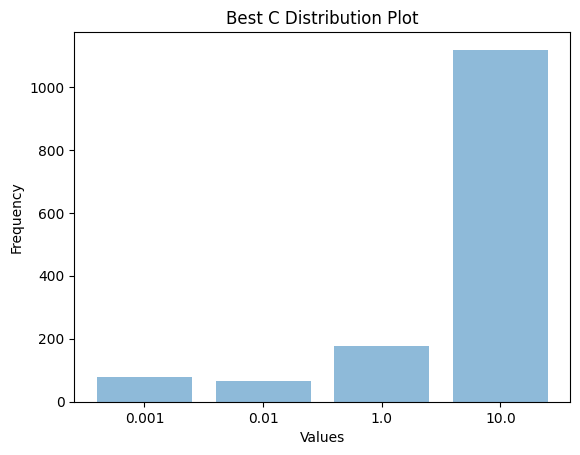

In [12]:
count = collections.Counter(best_Cs)
labels, values = zip(*count.items())
labels, values = zip(*sorted(zip(labels, values)))
str_labels = [str(label) for label in labels]  # Convert labels to strings
plt.bar(str_labels, values, align='center', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Best C Distribution Plot')
plt.xticks(str_labels)  # Use string labels for x ticks
plt.show()

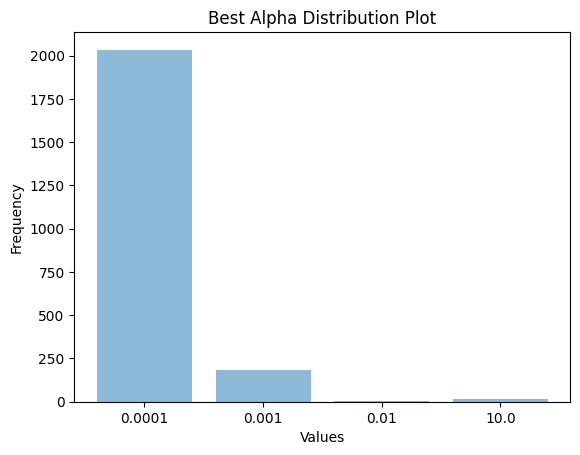

In [13]:
count = collections.Counter(best_alphas)
labels, values = zip(*count.items())
labels, values = zip(*sorted(zip(labels, values)))
str_labels = [str(label) for label in labels]  # Convert labels to strings
plt.bar(str_labels, values, align='center', alpha=0.5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Best Alpha Distribution Plot')
plt.xticks(str_labels)  # Use string labels for x ticks
plt.show()

/tmp/ipykernel_306/883036651.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5, 5))


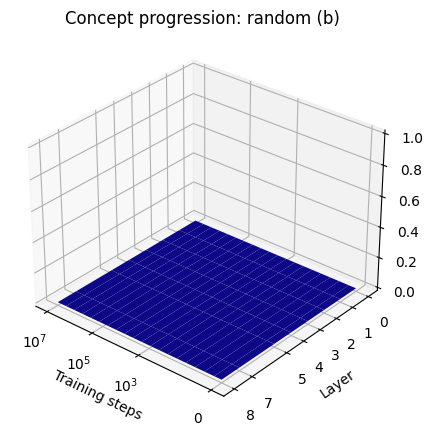

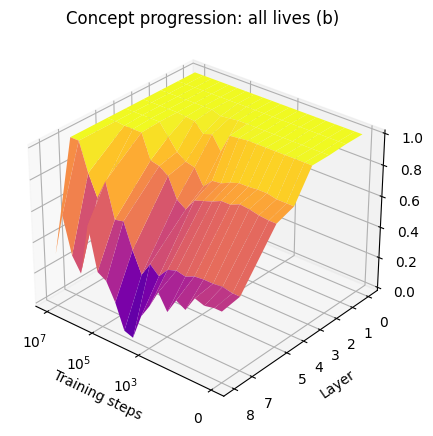

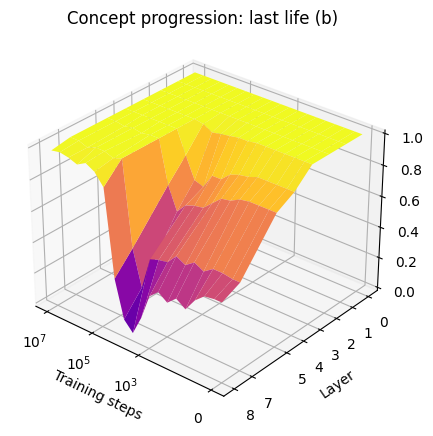

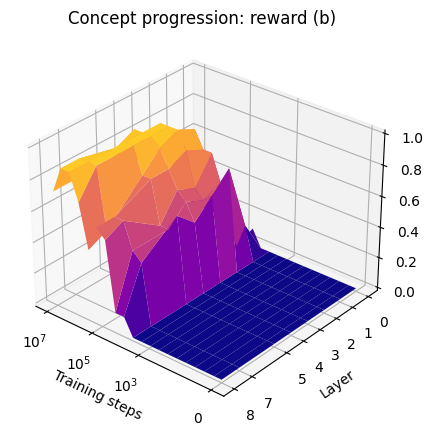

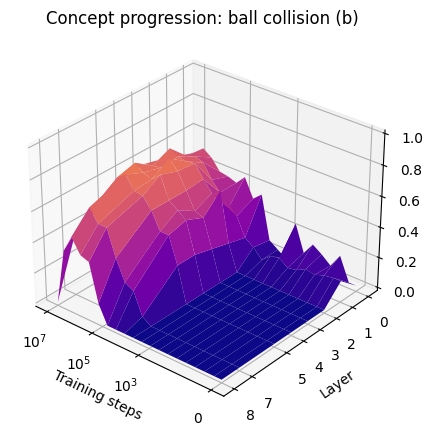

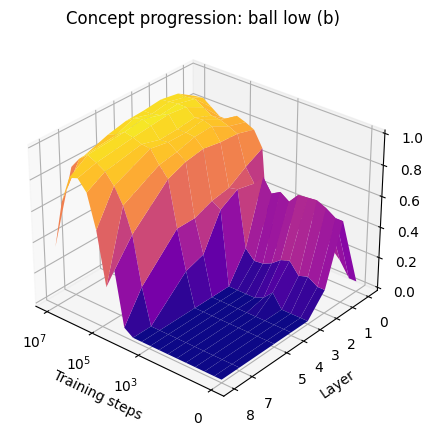

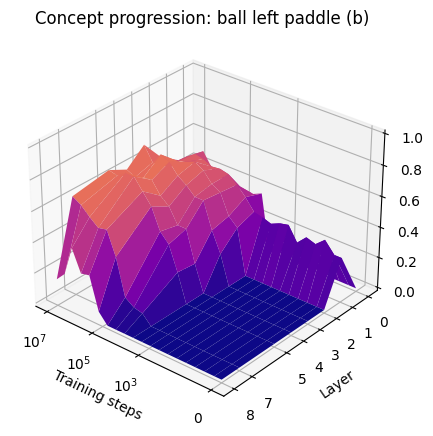

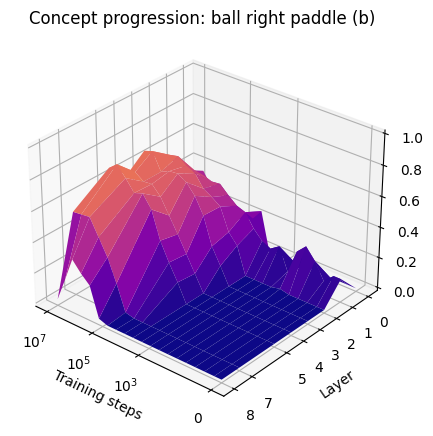

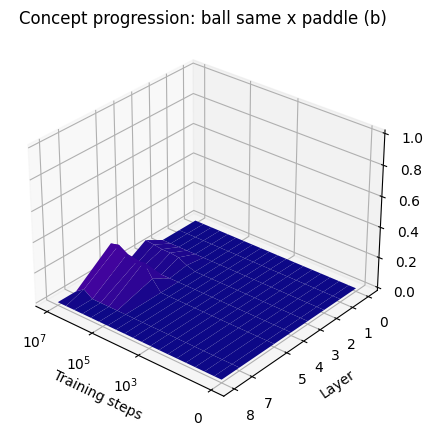

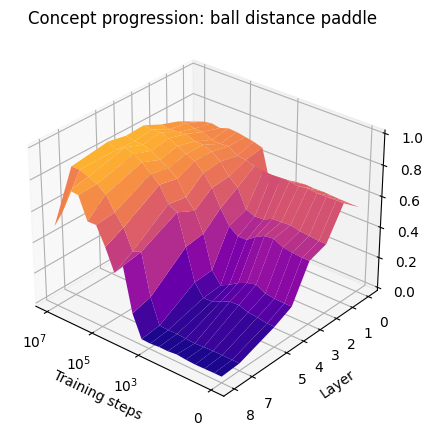

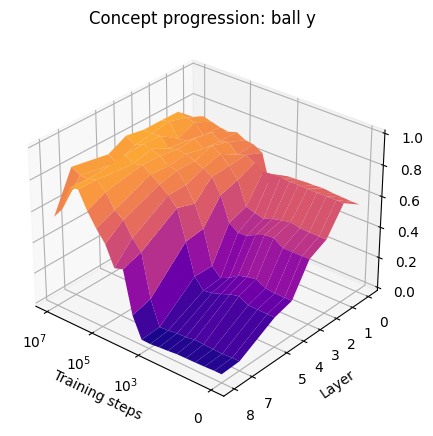

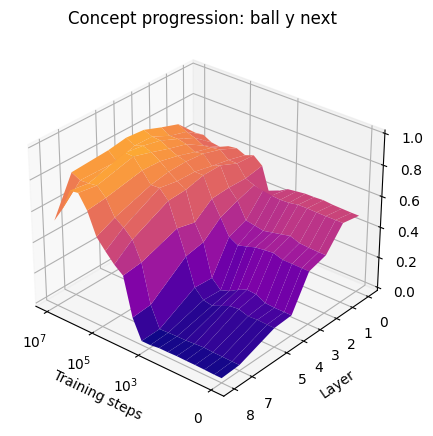

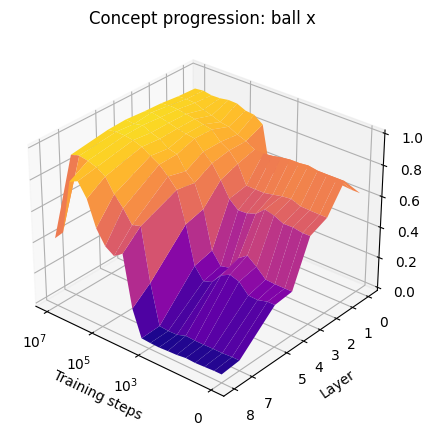

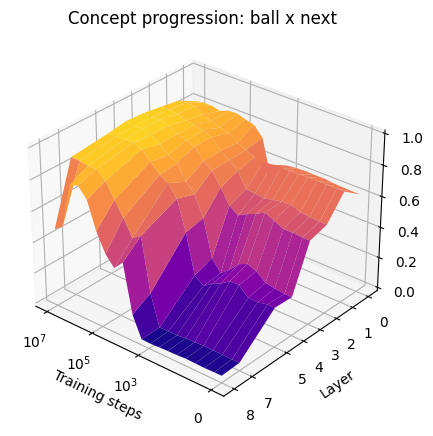

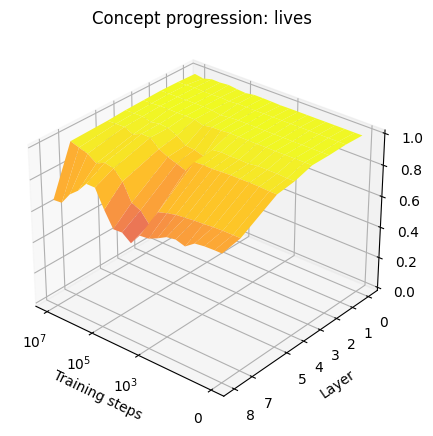

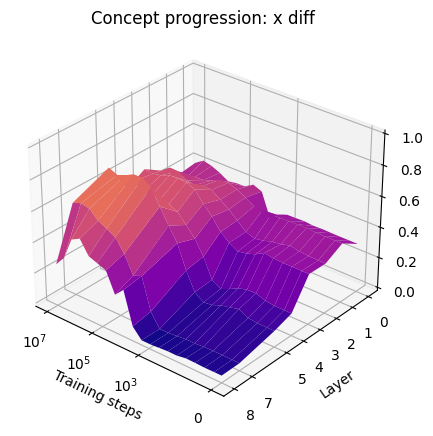

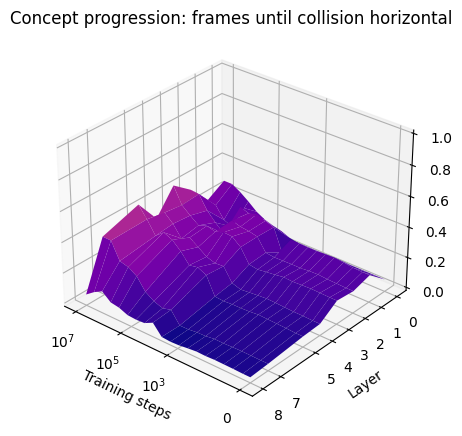

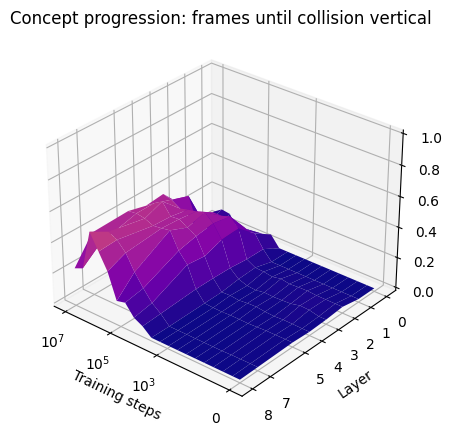

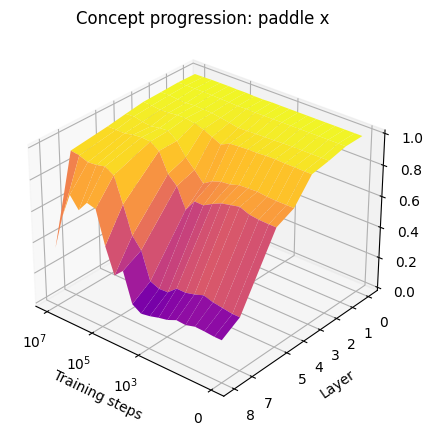

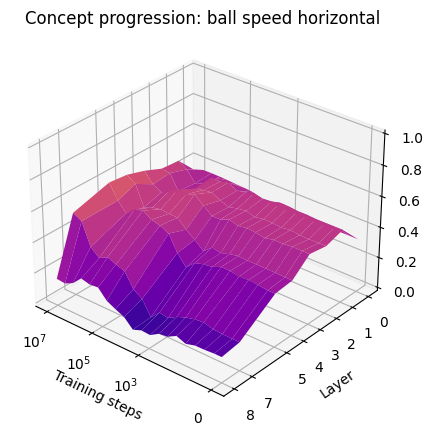

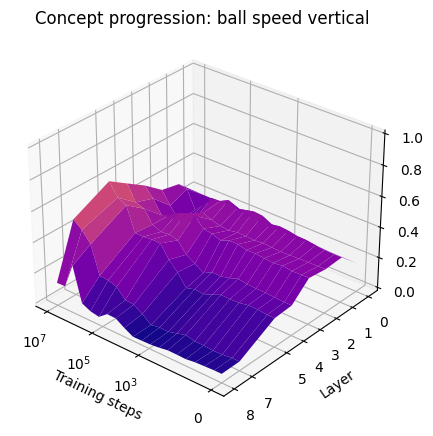

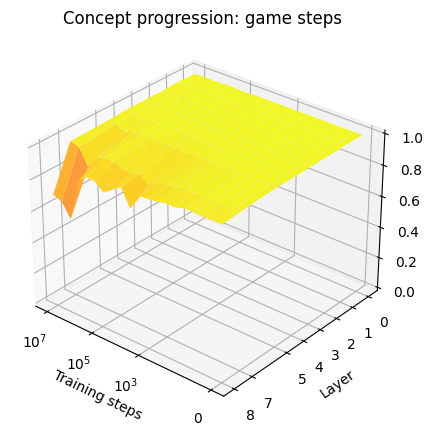

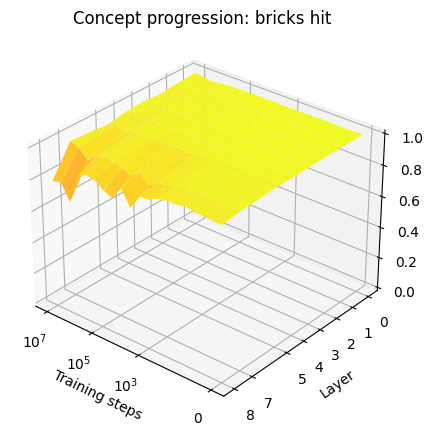

In [23]:
train_steps = np.array(train_steps)
# surface plot accuracies, log10 scale for training steps
for concept in concept_instances.values():
    data = scores[concept.name]

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.set_title(f'Concept progression: {concept.name}')
    ax.view_init(elev=30, azim=-230)
    ax.plot_surface(np.log10(data['x']+1), data['y'], np.maximum(0, data['z']), cmap=cm.plasma, vmin=0, vmax=1)

    ax.set_xlabel('Training steps')
    ax.set_xticks(np.log10([1, 10**3, 10**5, 10**7]))
    ax.set_xticklabels(['$0$', '$10^3$', '$10^5$', '$10^7$'])

    ax.set_ylabel('Layer')
    ax.set_yticks(layers)
    ax.set_yticklabels(layers)

    ax.set_zlabel('Score')
    ax.set_zlim(0, 1)
    
    plt.savefig(f'{concept.path}/concept_progression.png')

In [15]:
# Do the same but for linear regression on observation (not activations)
input_score = {}

for concept in concept_instances.values():
    obs_train = concept.obs_train.reshape(len(concept.obs_train), -1)
    obs_test = concept.obs_test.reshape(len(concept.obs_test), -1)
    if concept.binary:
        reg, score = calculate_accuracy(obs_train, concept.values_train, obs_test, concept.values_test)
    else:
        reg, score = calculate_r2(obs_train, concept.values_train, obs_test, concept.values_test)
    input_score[concept.name] = max(0, score)
    print(concept.name, score)

(0.001, 0.026666666666666616) random (b) -0.9466666666666668
(0.001, 1.0) all lives (b) 1.0
(0.001, 1.0) last life (b) 1.0
(1.0, 0.4444444444444444) reward (b) -0.11111111111111116
(10.0, 0.6624040920716112) ball collision (b) 0.32480818414322243
(10.0, 0.8433333333333333) ball low (b) 0.6866666666666665
(10.0, 0.6200000000000001) ball left paddle (b) 0.2400000000000002
(10.0, 0.53) ball right paddle (b) 0.06000000000000005
(10.0, 0.35125448028673834) ball same x paddle (b) -0.29749103942652333
(0.01, 0.6075767509251739) ball distance paddle 0.6075767509251739
(0.01, 0.5680250555676036) ball y 0.5680250555676036
(0.01, 0.4540176564659847) ball y next 0.4540176564659847
(0.001, 0.6108828097376224) ball x 0.6108828097376224
(0.01, 0.6277337046845282) ball x next 0.6277337046845282
(0.01, 0.9961275446872447) lives 0.9961275446872447
(0.01, 0.23567261731441036) x diff 0.23567261731441036
(1.0, 0.06633967222400805) frames until collision horizontal 0.06633967222400805
(1.0, 0.02079332719178

### Replot but add input score

/tmp/ipykernel_306/2120868011.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5, 5))


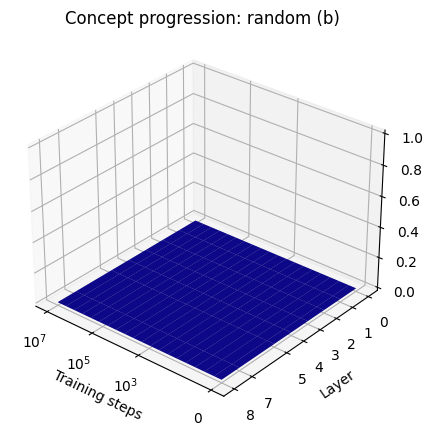

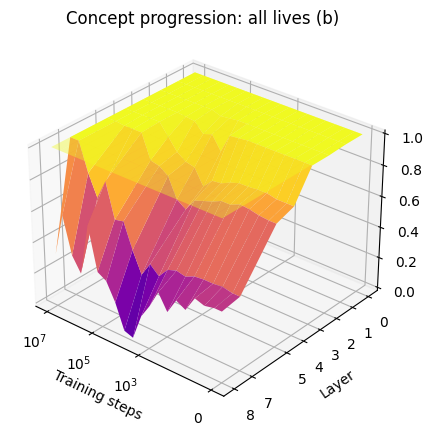

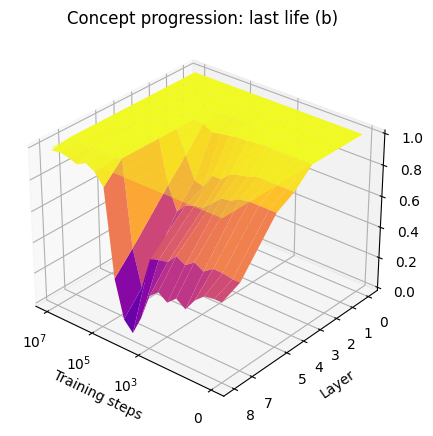

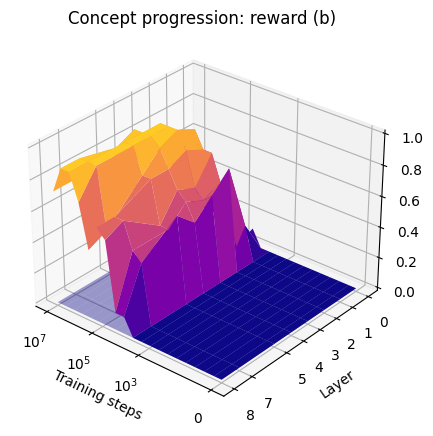

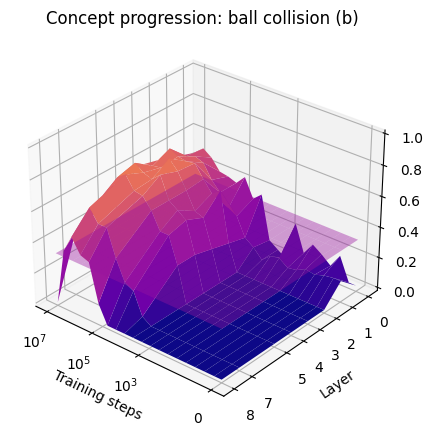

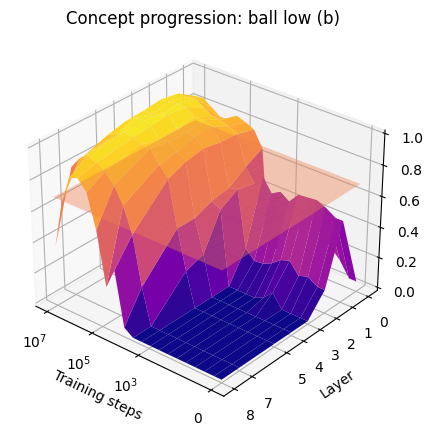

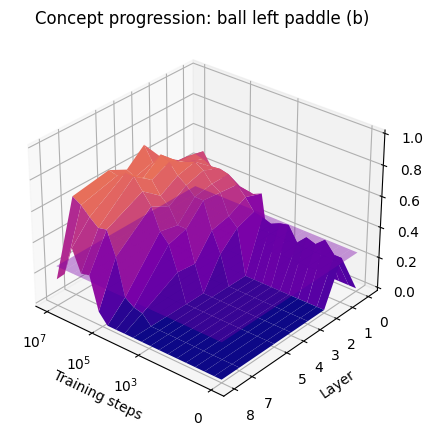

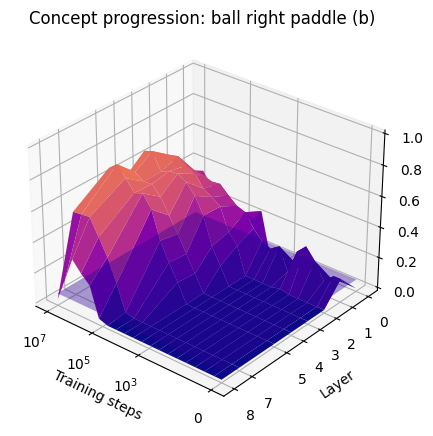

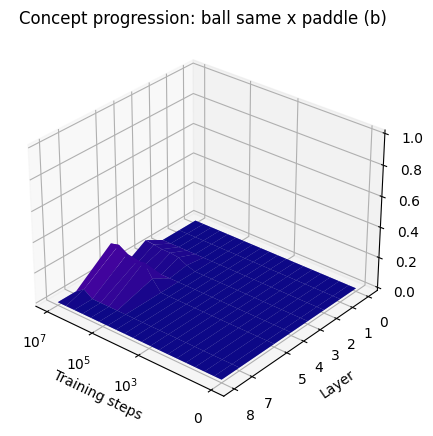

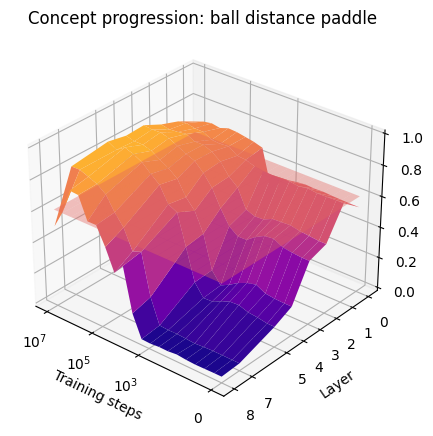

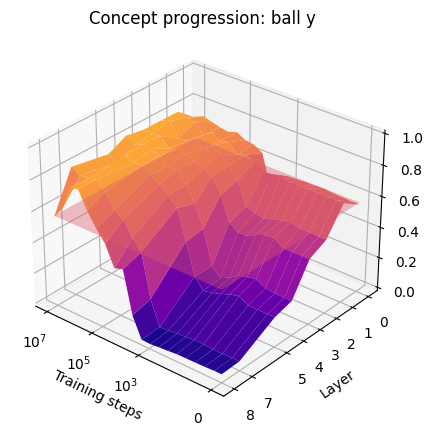

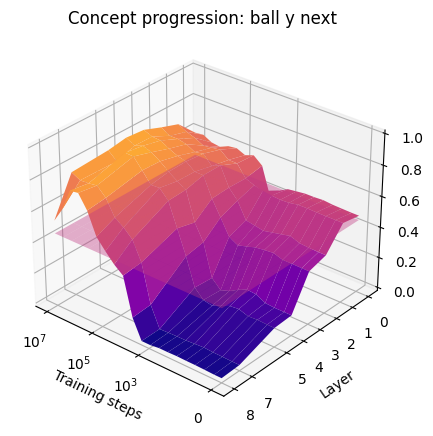

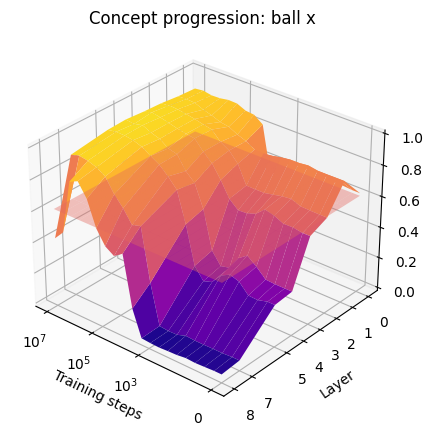

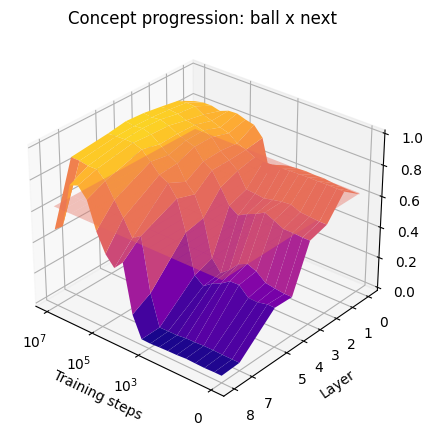

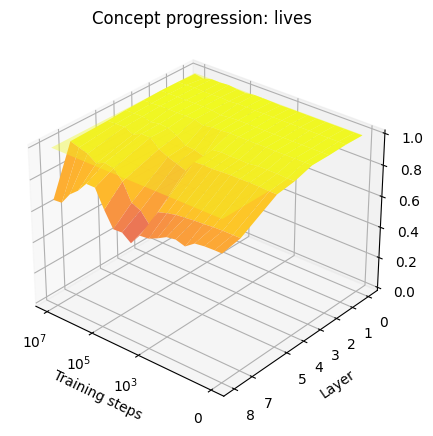

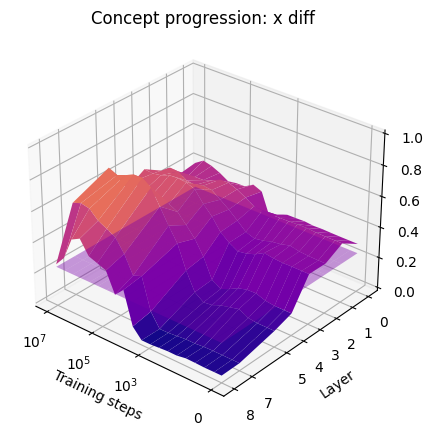

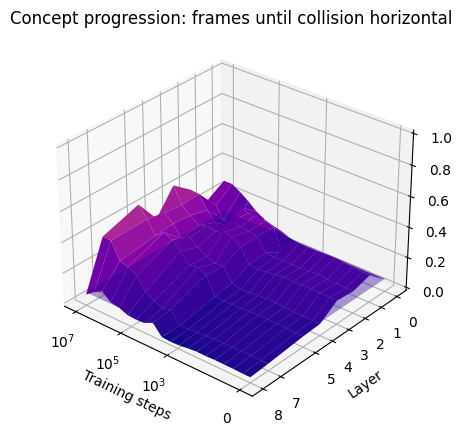

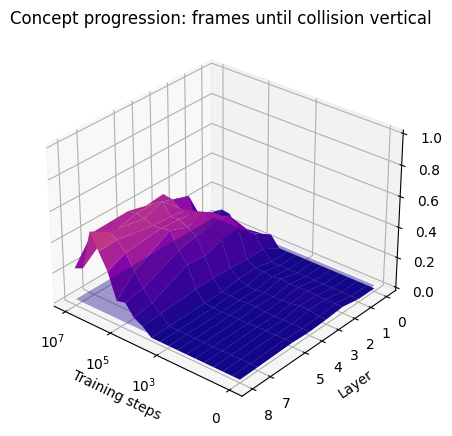

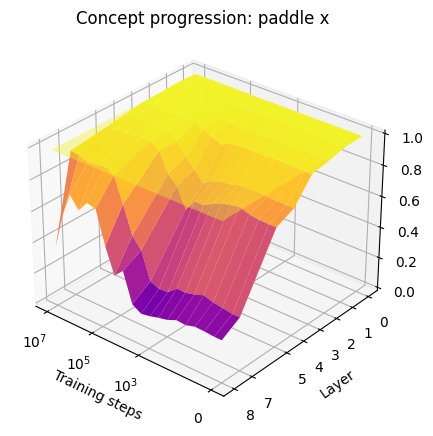

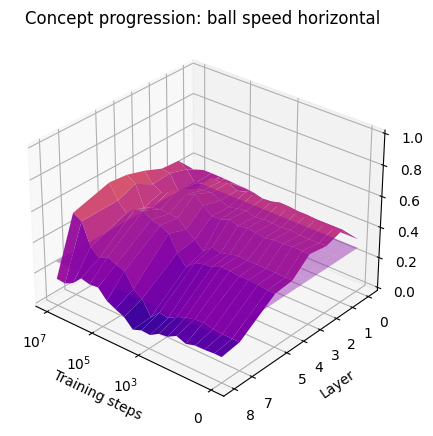

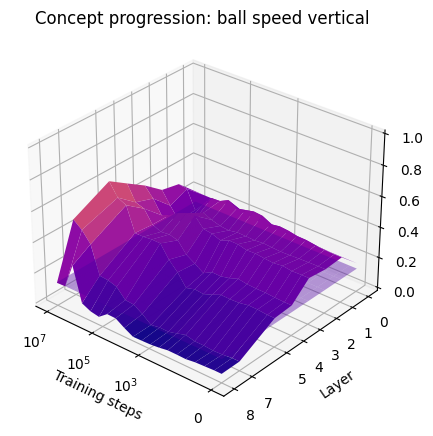

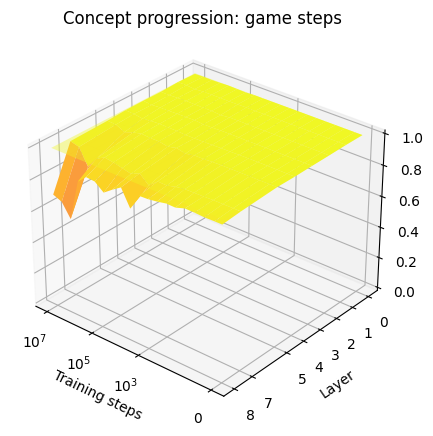

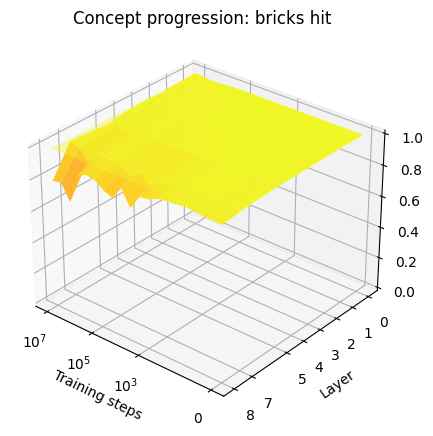

In [22]:
train_steps = np.array(train_steps)
# surface plot accuracies, log10 scale for training steps
for concept in concept_instances.values():
    z = scores[concept.name]['z']
    z_input = np.full(z.shape, input_score[concept.name])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.set_title(f'Concept progression: {concept.name}')
    ax.view_init(elev=30, azim=-230)
    ax.plot_surface(np.log10(data['x']+1), data['y'], z_input, vmin=0, vmax=1, alpha=0.4, cmap=cm.plasma)
    ax.plot_surface(np.log10(data['x']+1), data['y'], np.maximum(0, z), cmap=cm.plasma, vmin=0, vmax=1)

    ax.set_xlabel('Training steps')
    ax.set_xticks(np.log10([1, 10**3, 10**5, 10**7]))
    ax.set_xticklabels(['$0$', '$10^3$', '$10^5$', '$10^7$'])

    ax.set_ylabel('Layer')
    ax.set_yticks(layers)
    ax.set_yticklabels(layers)

    ax.set_zlabel('Score')
    ax.set_zlim(0, 1)
    
    plt.savefig(f'{concept.path}/concept_progression_modified.png')